#  Cleaning and Inventory

In this pack there are 326 stroke patients which have a total of 8454 images associated. Using the folder of images that we receive from the hospital X, we create the part1_inventory_test.csv which contains all the metadata of the received images. The initial file format follows the DICOM standard, which you can check here: https://dicom.innolitics.com/ciods. In the part1_inventory_test.csv file each row represents an image in the package, and each column a dicom standard metadata field.

In order to apply our deep learning algorithms to this dataset, we first have to select the correct NCCT (Non-Contrast CT) image (out of the many images that we have) for each patient. Selecting the right NCCT is critical to achieve a good performance in the clinical study or to train a good algorithm. 

The challenge consists on a small simplified version of this task: 

● Select the correct NCCT image for each of the 326 patients. 

● The correct NCCT must meet the following characteristics: non-contrast image, CT modality, axial orientation, slice thickness between 2.5 and 5 mm’s, first (in time) NCCT acquired. 

Some hints on the data: 

● A patient (PatientID) may have several studies (StudyInstanceUID - group of images), and within the study there can be many images (SeriesInstanceUID - single image).

● Each row of the part1_inventory_test.csv is the metadata of the image (unique SeriesInstanceUID). 

● In this inventory you may find different kinds of image modalities: CT (NCCT or CTA), DWI, MRI, CTP, etc. Note that the DICOM modality column is not enough to complete the exercise, as NCCT and CTA are both CTs.

● The most difficult ambiguity to discern using only image metadata is whether the image is an NCCT or a CTA, you have an image above of how they look (A CTA is a CT acquisition with an injection of contrast in the patient's arteries).

● Other important data fields: Modality, ImageOrientationPatient, SeriesDescription, StudyDescription, ImageType, SliceThickness, etc. 

Since we have already solved it, we will provide you with an example of 25 selected NCCT images (example_solution.csv) with some relevant fields, in order to show you an example of how the final result should look like. 

### Data Loading

In [1]:
import pandas as pd

In [3]:
df = pd.read_csv('data/part1_inventory_test.csv',low_memory = False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8454 entries, 0 to 8453
Columns: 206 entries, PatientID to RouteOfAdmissions
dtypes: float64(113), int64(13), object(80)
memory usage: 13.3+ MB


In [5]:
solution_df = pd.read_csv('data/example_solution.csv',low_memory = False)

In [6]:
solution_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PatientID          25 non-null     object 
 1   StudyInstanceUID   25 non-null     object 
 2   SeriesInstanceUID  25 non-null     object 
 3   StudyDescription   25 non-null     object 
 4   SeriesDescription  25 non-null     object 
 5   PixelSpacing       25 non-null     object 
 6   SliceThickness     25 non-null     float64
 7   ConvolutionKernel  25 non-null     object 
dtypes: float64(1), object(7)
memory usage: 1.7+ KB


In [7]:
filtered_columns = list(solution_df.columns) + ['ImageOrientationPatient','Modality','InstanceCreationDate','InstanceCreationTime']
filtered_columns

['PatientID',
 'StudyInstanceUID',
 'SeriesInstanceUID',
 'StudyDescription',
 'SeriesDescription',
 'PixelSpacing',
 'SliceThickness',
 'ConvolutionKernel',
 'ImageOrientationPatient',
 'Modality',
 'InstanceCreationDate',
 'InstanceCreationTime']

In [8]:
df = df[filtered_columns]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8454 entries, 0 to 8453
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PatientID                8454 non-null   object 
 1   StudyInstanceUID         8454 non-null   object 
 2   SeriesInstanceUID        8454 non-null   object 
 3   StudyDescription         8454 non-null   object 
 4   SeriesDescription        8453 non-null   object 
 5   PixelSpacing             8365 non-null   object 
 6   SliceThickness           7410 non-null   float64
 7   ConvolutionKernel        5033 non-null   object 
 8   ImageOrientationPatient  7709 non-null   object 
 9   Modality                 8454 non-null   object 
 10  InstanceCreationDate     2593 non-null   float64
 11  InstanceCreationTime     2593 non-null   float64
dtypes: float64(3), object(9)
memory usage: 792.7+ KB


### Removing columns with < 30% NaN's 

In [10]:
threshold = int(df.shape[0] * 0.3)
df = df.dropna(axis=1, thresh=threshold)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8454 entries, 0 to 8453
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PatientID                8454 non-null   object 
 1   StudyInstanceUID         8454 non-null   object 
 2   SeriesInstanceUID        8454 non-null   object 
 3   StudyDescription         8454 non-null   object 
 4   SeriesDescription        8453 non-null   object 
 5   PixelSpacing             8365 non-null   object 
 6   SliceThickness           7410 non-null   float64
 7   ConvolutionKernel        5033 non-null   object 
 8   ImageOrientationPatient  7709 non-null   object 
 9   Modality                 8454 non-null   object 
 10  InstanceCreationDate     2593 non-null   float64
 11  InstanceCreationTime     2593 non-null   float64
dtypes: float64(3), object(9)
memory usage: 792.7+ KB


## Modality == 'CT'

In [12]:
df.Modality.unique()

array(['CT', 'MR', 'OT', 'XA'], dtype=object)

In [13]:
modality_df = df[df.Modality == 'CT']

In [14]:
modality_df.PatientID.unique().size

326

## Axial Orientation == ['1', '0', '0', '0', '1', '0']

In [15]:
df[df.ImageOrientationPatient == '1\\0\\0\\0\\1\\0'].PatientID.unique().size

306

Defining 0.15 tolerance for Axial Orientation

In [16]:
def tolerance(value, target, tolerance=0.15):
    if pd.isna(value):  # Check for NaN
        return False
    
    # Convert value to string and split
    components = list(map(float, str(value).split('\\')))
    target_components = list(map(float, target.split('\\')))
    
    return all(abs(comp - tgt) <= tolerance for comp, tgt in zip(components, target_components))

# Target string to compare against
target_value = '1\\0\\0\\0\\1\\0'

# Filtering the DataFrame based on closeness to the target value
axial_df = modality_df[modality_df.ImageOrientationPatient.apply(lambda x: tolerance(x, target_value))]

In [17]:
axial_df.PatientID.unique().size

324

In [18]:
axial_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4433 entries, 1 to 8447
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PatientID                4433 non-null   object 
 1   StudyInstanceUID         4433 non-null   object 
 2   SeriesInstanceUID        4433 non-null   object 
 3   StudyDescription         4433 non-null   object 
 4   SeriesDescription        4433 non-null   object 
 5   PixelSpacing             4433 non-null   object 
 6   SliceThickness           4403 non-null   float64
 7   ConvolutionKernel        3273 non-null   object 
 8   ImageOrientationPatient  4433 non-null   object 
 9   Modality                 4433 non-null   object 
 10  InstanceCreationDate     317 non-null    float64
 11  InstanceCreationTime     317 non-null    float64
dtypes: float64(3), object(9)
memory usage: 450.2+ KB


## Slice Thickness between 2.5 and 5 mm

In [19]:
thickness_df = axial_df[(axial_df.SliceThickness >= 2.5) & (axial_df.SliceThickness <= 5)]

In [20]:
thickness_df.PatientID.unique().size

313

In [21]:
thickness_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 965 entries, 1 to 8407
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PatientID                965 non-null    object 
 1   StudyInstanceUID         965 non-null    object 
 2   SeriesInstanceUID        965 non-null    object 
 3   StudyDescription         965 non-null    object 
 4   SeriesDescription        965 non-null    object 
 5   PixelSpacing             965 non-null    object 
 6   SliceThickness           965 non-null    float64
 7   ConvolutionKernel        786 non-null    object 
 8   ImageOrientationPatient  965 non-null    object 
 9   Modality                 965 non-null    object 
 10  InstanceCreationDate     17 non-null     float64
 11  InstanceCreationTime     17 non-null     float64
dtypes: float64(3), object(9)
memory usage: 98.0+ KB


## Series Description containing 'Head' or 'Brain'

In [22]:
df.SeriesDescription.unique().size

772

In [23]:
solution_df.SeriesDescription.unique()

array(['Head__5_0__J37s__1', 'Head__3_0__J30s', 'Head_5_0',
       'brain_Head_3_0', 'noncontrast_Head_3_0', 'brain_ST_Head_3_0',
       'Head_SPIRAL_Spiral', 'Head__3_0__J37s__1', 'AXIAL_HEAD',
       'noncontrast_Head_3_000', 'Head_3_0__Axial____FC64',
       'HEAD_3_75mm_Soft', 'Head_WO__3_0__J30f__SOFT'], dtype=object)

In [24]:
# Filtering based on 'Head', 'HEAD', or 'Brain' in 'SeriesDescription'
seriesdesc_df = thickness_df[
    thickness_df.SeriesDescription.str.contains('head|brain', case=False, na=False)
]

In [25]:
seriesdesc_df.PatientID.unique().size

307

In [26]:
seriesdesc_df.SeriesDescription.unique().size

62

In [27]:
seriesdesc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 755 entries, 1 to 8407
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PatientID                755 non-null    object 
 1   StudyInstanceUID         755 non-null    object 
 2   SeriesInstanceUID        755 non-null    object 
 3   StudyDescription         755 non-null    object 
 4   SeriesDescription        755 non-null    object 
 5   PixelSpacing             755 non-null    object 
 6   SliceThickness           755 non-null    float64
 7   ConvolutionKernel        747 non-null    object 
 8   ImageOrientationPatient  755 non-null    object 
 9   Modality                 755 non-null    object 
 10  InstanceCreationDate     5 non-null      float64
 11  InstanceCreationTime     5 non-null      float64
dtypes: float64(3), object(9)
memory usage: 76.7+ KB


## Study Description not containing 'Angio' or 'CTA HEAD'

Not sure about:
    
CT BRAIN WO, CTA BRAIN & CEREBRAL PERFUSION (70496, 0042T) -> included in solution

CT ANGIO HEAD & NECK W/WO (70496, 70498) -> not included in solution

CT ANGIO HEAD W/WO CONTRAST (70496) ->not included in solution

In [28]:
df.StudyDescription.unique()

array(['CT BRAIN WO CONTRAST (70450)',
       'CT BRAIN WO, CTA BRAIN & CEREBRAL PERFUSION (70496, 0042T)',
       'MRI BRAIN W/WO CONTRAST (70553)',
       'CT ANGIO HEAD & NECK W/WO (70496, 70498)',
       'CTA BRAIN & CEREBRAL PERFUSION (70496, 0042T)',
       'EXTERNAL CT-STORE & INTERPRET',
       'CT ANGIO HEAD W/WO CONTRAST (70496)', 'EXTERNAL CT - STORE ONLY',
       'MRI BRAIN WO CONTRAST (70551)', 'EXTERNAL CT - STORE ONLY - RAD',
       'IR NEURO RADIOLOGY PROCEDURE',
       'EXTERNAL CT BRAIN - STORE ONLY - RAD',
       'EXTERNAL CTA HEAD - STORE ONLY - RAD',
       'EXTERNAL CT BRAIN - STORE ONLY', 'EXTERNAL CTA HEAD - STORE ONLY',
       'EXTERNAL CT BRAIN INTERPRET', 'EXTERNAL CTA HEAD INTERPRET'],
      dtype=object)

In [29]:
solution_df.StudyDescription.unique()

array(['CT BRAIN WO, CTA BRAIN & CEREBRAL PERFUSION (70496, 0042T)',
       'EXTERNAL CT - STORE ONLY', 'EXTERNAL CT - STORE ONLY - RAD',
       'EXTERNAL CT BRAIN - STORE ONLY - RAD',
       'EXTERNAL CT BRAIN - STORE ONLY', 'CT BRAIN WO CONTRAST (70450)',
       'EXTERNAL CT BRAIN INTERPRET'], dtype=object)

In [30]:
# Filter StudyDescription to exclude CTA or Angio
studydesc_df = seriesdesc_df[
    (~seriesdesc_df.StudyDescription.str.contains('angio|CTA HEAD', case=False, na=False))
]

In [31]:
studydesc_df.StudyDescription.unique()

array(['CT BRAIN WO CONTRAST (70450)',
       'CT BRAIN WO, CTA BRAIN & CEREBRAL PERFUSION (70496, 0042T)',
       'EXTERNAL CT-STORE & INTERPRET',
       'CTA BRAIN & CEREBRAL PERFUSION (70496, 0042T)',
       'EXTERNAL CT - STORE ONLY', 'EXTERNAL CT - STORE ONLY - RAD',
       'EXTERNAL CT BRAIN - STORE ONLY - RAD',
       'EXTERNAL CT BRAIN - STORE ONLY', 'EXTERNAL CT BRAIN INTERPRET'],
      dtype=object)

In [32]:
studydesc_df.PatientID.unique().size

305

In [33]:
studydesc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 1 to 8407
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PatientID                720 non-null    object 
 1   StudyInstanceUID         720 non-null    object 
 2   SeriesInstanceUID        720 non-null    object 
 3   StudyDescription         720 non-null    object 
 4   SeriesDescription        720 non-null    object 
 5   PixelSpacing             720 non-null    object 
 6   SliceThickness           720 non-null    float64
 7   ConvolutionKernel        712 non-null    object 
 8   ImageOrientationPatient  720 non-null    object 
 9   Modality                 720 non-null    object 
 10  InstanceCreationDate     5 non-null      float64
 11  InstanceCreationTime     5 non-null      float64
dtypes: float64(3), object(9)
memory usage: 73.1+ KB


## Pixel Spacing less than 0.55,0.55 mm

Study if it's needed to determine a threshold for this value

In [34]:
df.PixelSpacing.unique().size

863

In [35]:
solution_df.PixelSpacing.unique()

array(['[0.46875, 0.46875]', '[0.47265625, 0.47265625]', '[0.417, 0.417]',
       '[0.456, 0.456]', '[0.517, 0.517]', '[0.430, 0.430]',
       '[0.455078125, 0.455078125]', '[0.39086294416244, 0.390625]',
       '[0.390625, 0.390625]', '[0.527000, 0.527000]', '[0.429, 0.429]',
       '[0.451171875, 0.451171875]', '[0.454, 0.454]',
       '[0.488281, 0.488281]', '[0.459, 0.459]', '[0.4296875, 0.4296875]',
       '[0.38850174216028, 0.388671875]'], dtype=object)

In [36]:
studydesc_df.PixelSpacing.unique()

array(['0.46875\\0.46875', '0.36156351791531\\0.361328125',
       '0.25390625\\0.25390625', '0.3828125\\0.3828125',
       '0.37109375\\0.37109375', '0.48046875\\0.48046875',
       '0.412109375\\0.412109375', '0.392578125\\0.392578125',
       '0.392578125\\0.39279869067103', '0.396484375\\0.396484375',
       '0.37890625\\0.37890625', '0.427734375\\0.427734375',
       '0.41030534351145\\0.41015625', '0.33177570093458\\0.33203125',
       '0.515625\\0.515625', '0.390625\\0.390625', '0.488281\\0.488281',
       '0.556640625\\0.556640625', '0.5703125\\0.5703125',
       '0.4296875\\0.4296875', '0.4921875\\0.4921875',
       '1.033203125\\1.033203125', '1.029296875\\1.029296875',
       '0.51953125\\0.51953125', '1.02734375\\1.02734375',
       '0.9765625\\0.9765625', '1.03125\\1.03125',
       '1.037109375\\1.037109375', '0.978515625\\0.978515625',
       '1.03515625\\1.03515625', '0.98046875\\0.98046875',
       '0.541015625\\0.541015625', '0.533203125\\0.533203125',
       '0.468\\0

In [37]:
def filter_pixel_spacing(value):
    # Split the PixelSpacing string
    values = value.split('\\')
    
    # Convert the split values into floats
    val1 = float(values[0])
    val2 = float(values[1])
    
    # Check if both values are less than or equal to 0.53
    return val1 <= 0.55 and val2 <= 0.55

In [38]:
pixelsp_df = studydesc_df[studydesc_df.PixelSpacing.apply(filter_pixel_spacing)]

In [39]:
pixelsp_df.PatientID.unique().size

305

In [40]:
pixelsp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 1 to 8407
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PatientID                699 non-null    object 
 1   StudyInstanceUID         699 non-null    object 
 2   SeriesInstanceUID        699 non-null    object 
 3   StudyDescription         699 non-null    object 
 4   SeriesDescription        699 non-null    object 
 5   PixelSpacing             699 non-null    object 
 6   SliceThickness           699 non-null    float64
 7   ConvolutionKernel        691 non-null    object 
 8   ImageOrientationPatient  699 non-null    object 
 9   Modality                 699 non-null    object 
 10  InstanceCreationDate     5 non-null      float64
 11  InstanceCreationTime     5 non-null      float64
dtypes: float64(3), object(9)
memory usage: 71.0+ KB


## First in time NCTT Created

Decided not to be included in the filter criteria as it affected few cases and both images could be useful for the algorithm

In [41]:
df.columns[df.columns.str.contains('creation', case=False)]


Index(['InstanceCreationDate', 'InstanceCreationTime'], dtype='object')

In [42]:
pixelsp_df[pixelsp_df.InstanceCreationDate.notnull()]

,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyDescription,SeriesDescription,PixelSpacing,SliceThickness,ConvolutionKernel,ImageOrientationPatient,Modality,InstanceCreationDate,InstanceCreationTime
1876,B27,1.3.12.2.1107.5.1.4.25049902636933607762377742...,1.3.12.2.1107.5.1.4.76676095302909735651073058...,EXTERNAL CT-STORE & INTERPRET,HELICAL_HEAD,0.488281\0.488281,2.50,STANDARD,1.000000\0.000000\0.000000\0.000000\1.000000\0...,CT,20210826.0,45449.00
1877,B27,1.3.12.2.1107.5.1.4.25049902636933607762377742...,1.3.12.2.1107.5.1.4.22045256542742356661705839...,EXTERNAL CT-STORE & INTERPRET,Recon_2__HELICAL_HEAD,0.488281\0.488281,2.50,BONE,1.000000\0.000000\0.000000\0.000000\1.000000\0...,CT,20210826.0,45512.00
6067,E135,1.3.12.2.1107.5.1.4.89209744840729005094034996...,1.3.12.2.1107.5.1.4.25536946662983948546072232...,EXTERNAL CT - STORE ONLY,Brain___PACS,0.468\0.468,5.00,54,1.0000\0.0000\0.0000\0.0000\1.0000\0.0000,CT,20211115.0,80258.06
8211,G63,1.3.12.2.1107.5.1.4.55310721004101065623387228...,1.3.12.2.1107.5.1.4.94258543244212945685053721...,EXTERNAL CT BRAIN - STORE ONLY,HEAD_3_75mm_Soft,0.488281\0.488281,3.75,STANDARD,1.000000\0.000000\0.000000\0.000000\1.000000\0...,CT,20211209.0,195705.00
8213,G63,1.3.12.2.1107.5.1.4.55310721004101065623387228...,1.3.12.2.1107.5.1.4.56131535116631380105618367...,EXTERNAL CT BRAIN - STORE ONLY,Head_2_5_Bone,0.488281\0.488281,2.50,STANDARD,1.000000\0.000000\0.000000\0.000000\1.000000\0...,CT,20211209.0,195755.00


## Convolution Kernel

Decided not to use it for this prior study

In [43]:
df.ConvolutionKernel.unique() 

array(['T20f', 'J37s\\1', 'J70h\\1', 'Tr20f', 'Hc40s\\2', 'Br64s\\2', nan,
       'T80f', 'H20f', 'Hr36d', 'H41s', 'H70h', 'Hr38s\\2', 'Br64s\\3',
       'J37f\\1', 'Q40f\\1', 'Hr68h\\2', 'J30f\\2', 'T20s', 'H37s',
       'H40s', 'STANDARD', 'BONE', 'H41f', 'UC', 'H31f', 'H60f',
       'I30f\\3', 'I40f\\3', 'B30f', 'H31s', 'FC03', 'FL04', 'FL03',
       'FC43', 'J37s\\3', 'J70h\\3', 'Hc40s', 'I40s\\3', 'B60s', 'B70s',
       'Hc40s\\3', 'Bv36d\\3', 'Bv36d', 'LUNG', 'J37f\\3', 'H40f', 'H10s',
       'I80s\\1', 'J40s\\2', 'I30f\\2', 'J30f\\3', 'H60s', '01', '54',
       '42', '12', 'SOFT', 'FC21', 'FC30', 'J30s\\1', 'FC26', 'I40f\\2',
       'B20f', 'FC68', 'FC35', 'BONEPLUS', 'FC41', 'H50s', 'FC64',
       'Qr36d\\3', 'Qr40s\\2'], dtype=object)

In [44]:
solution_df.ConvolutionKernel.unique()

array(["['J37s', '1']", "['J30s', '1']", 'FC26', 'FC68', 'FC21', 'H31f',
       'FC64', 'STANDARD', "['J30f', '3']"], dtype=object)

In [45]:
pixelsp_df.ConvolutionKernel.unique()

array(['J37s\\1', 'J70h\\1', 'Hc40s\\2', 'Br64s\\2', 'H41s', 'H70h',
       'Hr38s\\2', nan, 'J37f\\1', 'Q40f\\1', 'Hr68h\\2', 'H37s', 'H40s',
       'STANDARD', 'BONE', 'H41f', 'H31f', 'H31s', 'Hc40s\\3', 'J40s\\2',
       'J70h\\3', 'J30f\\3', 'H60f', '54', 'FC21', 'J30s\\1', 'FC68',
       'H60s', 'FC30'], dtype=object)

## Further analysis, SeriesInstanceUID that are duplicated?

This was determined not to be considered 

In [46]:
filtered_df = df[~df.duplicated(subset=['SeriesInstanceUID'], keep='first')]

In [47]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8299 entries, 0 to 8453
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PatientID                8299 non-null   object 
 1   StudyInstanceUID         8299 non-null   object 
 2   SeriesInstanceUID        8299 non-null   object 
 3   StudyDescription         8299 non-null   object 
 4   SeriesDescription        8298 non-null   object 
 5   PixelSpacing             8213 non-null   object 
 6   SliceThickness           7267 non-null   float64
 7   ConvolutionKernel        4943 non-null   object 
 8   ImageOrientationPatient  7565 non-null   object 
 9   Modality                 8299 non-null   object 
 10  InstanceCreationDate     2531 non-null   float64
 11  InstanceCreationTime     2531 non-null   float64
dtypes: float64(3), object(9)
memory usage: 842.9+ KB


In [48]:
filtered_df.PatientID.unique().size

323

In [49]:
filtered_df.StudyInstanceUID.unique().size

502

In [50]:
# Get duplicate SeriesInstanceUIDs
duplicate_series = filtered_df[filtered_df.SeriesInstanceUID.duplicated(keep=False)]

# Extract the unique duplicate SeriesInstanceUID values
unique_duplicate_series = duplicate_series.SeriesInstanceUID.unique()

## Compilation of Previous code - End of First Task

In [51]:
import pandas as pd

# Load the dataset with optimized memory usage
df = pd.read_csv('data/part1_inventory_test.csv', low_memory=False)

# Define the target columns to be used in the analysis
target_columns = ['PatientID',
                  'StudyInstanceUID',
                  'SeriesInstanceUID',
                  'StudyDescription',
                  'SeriesDescription',
                  'PixelSpacing',
                  'SliceThickness',
                  'ConvolutionKernel',
                  'ImageOrientationPatient',
                  'Modality']

# Filter DataFrame to include only the target columns and remove columns with more than 30% missing values
threshold = int(df.shape[0] * 0.3)
df = df[target_columns].dropna(axis=1, thresh=threshold)

# Filter for rows where the modality is 'CT' (Computed Tomography)
df = df[df.Modality == 'CT']

# Function to check if the ImageOrientationPatient values are within a tolerance of the target
def tolerance(value, target, tolerance=0.15):
    """Check if the orientation components of `value` are within the specified tolerance of `target`."""
    if pd.isna(value):  # Handle missing values
        return False
    
    # Convert value and target into lists of float components
    components = list(map(float, str(value).split('\\')))
    target_components = list(map(float, target.split('\\')))
    
    # Check if all components are within the tolerance range
    return all(abs(comp - tgt) <= tolerance for comp, tgt in zip(components, target_components))

# Define the target axial orientation to compare against
target_orientation = '1\\0\\0\\0\\1\\0'

# Filter based on closeness to the target axial orientation
df = df[df.ImageOrientationPatient.apply(lambda x: tolerance(x, target_orientation))]

# Filter rows where Slice Thickness is between 2.5 and 5 mm
df = df[(df.SliceThickness >= 2.5) & (df.SliceThickness <= 5)]

# Filter SeriesDescription to include only rows with 'head' or 'brain' (case insensitive)
df = df[df.SeriesDescription.str.contains('head|brain', case=False, na=False)]

# Filter StudyDescription to exclude rows with 'CTA HEAD' or 'Angio' (case insensitive)
df = df[~df.StudyDescription.str.contains('angio|CTA HEAD', case=False, na=False)]

# Function to filter PixelSpacing values where both components are less than or equal to 0.53 mm
def filter_pixel_spacing(value):
    """Return True if both components of PixelSpacing are <= 0.53 mm, otherwise False."""
    try:
        # Split the PixelSpacing into two values and convert them to floats
        val1, val2 = map(float, value.split('\\'))
    except (ValueError, AttributeError):
        return False  # Handle any potential issues with missing or malformed data
    
    # Check if both values are less than or equal to the threshold (0.53 mm)
    return val1 <= 0.55 and val2 <= 0.55

# Apply PixelSpacing filter to keep rows with PixelSpacing <= 0.53 mm for both dimensions
final_df = df[df.PixelSpacing.apply(filter_pixel_spacing)]

# Display the resulting filtered DataFrame
final_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 1 to 8407
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PatientID                699 non-null    object 
 1   StudyInstanceUID         699 non-null    object 
 2   SeriesInstanceUID        699 non-null    object 
 3   StudyDescription         699 non-null    object 
 4   SeriesDescription        699 non-null    object 
 5   PixelSpacing             699 non-null    object 
 6   SliceThickness           699 non-null    float64
 7   ConvolutionKernel        691 non-null    object 
 8   ImageOrientationPatient  699 non-null    object 
 9   Modality                 699 non-null    object 
dtypes: float64(1), object(9)
memory usage: 60.1+ KB


In [72]:
final_df.PatientID.unique().size

305

## ETL Integration

In [52]:
import pandas as pd
import logging

# Set up logging for the ETL process
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def extract_data(file_path):
    """Extract data from CSV file."""
    try:
        logging.info("Extracting data from CSV file.")
        df = pd.read_csv(file_path, low_memory=False)
        logging.info(f"Data extraction complete. Rows: {df.shape[0]}, Columns: {df.shape[1]}")
        return df
    except Exception as e:
        logging.error(f"Error during data extraction: {e}")
        raise

def transform_data(df):
    """Transform the data by filtering and processing."""
    logging.info("Starting data transformation.")

    # Define the target columns to be used in the analysis
    target_columns = ['PatientID',
                      'StudyInstanceUID',
                      'SeriesInstanceUID',
                      'StudyDescription',
                      'SeriesDescription',
                      'PixelSpacing',
                      'SliceThickness',
                      'ConvolutionKernel',
                      'ImageOrientationPatient',
                      'Modality']

    # Filter DataFrame to include only the target columns and remove columns with more than 30% missing values
    threshold = int(df.shape[0] * 0.3)
    df = df[target_columns].dropna(axis=1, thresh=threshold)

    # Filter for rows where the modality is 'CT'
    df = df[df.Modality == 'CT']

    # Function to check if the ImageOrientationPatient values are within a tolerance of the target
    def tolerance(value, target, tolerance=0.15):
        if pd.isna(value):
            return False
        components = list(map(float, str(value).split('\\')))
        target_components = list(map(float, target.split('\\')))
        return all(abs(comp - tgt) <= tolerance for comp, tgt in zip(components, target_components))

    # Target orientation to compare against
    target_orientation = '1\\0\\0\\0\\1\\0'
    df = df[df.ImageOrientationPatient.apply(lambda x: tolerance(x, target_orientation))]

    # Filter rows where Slice Thickness is between 2.5 and 5 mm
    df = df[(df.SliceThickness >= 2.5) & (df.SliceThickness <= 5)]

    # Filter SeriesDescription to include only rows with 'head' or 'brain'
    df = df[df.SeriesDescription.str.contains('head|brain', case=False, na=False)]

    # Filter StudyDescription to exclude rows with 'CTA HEAD' or 'Angio'
    df = df[~df.StudyDescription.str.contains('angio|CTA HEAD', case=False, na=False)]

    # Function to filter PixelSpacing values
    def filter_pixel_spacing(value):
        try:
            val1, val2 = map(float, value.split('\\'))
        except (ValueError, AttributeError):
            return False
        return val1 <= 0.55 and val2 <= 0.55

    # Apply PixelSpacing filter
    df = df[df.PixelSpacing.apply(filter_pixel_spacing)]

    logging.info(f"Data transformation complete. Rows after transformation: {df.shape[0]}")
    return df

def load_data(df, output_file):
    """Load transformed data to a CSV file."""
    try:
        logging.info(f"Loading data to {output_file}.")
        df.to_csv(output_file, index=False)
        logging.info("Data loading complete.")
    except Exception as e:
        logging.error(f"Error during data loading: {e}")
        raise

def main():
    """Main ETL function to orchestrate the process."""
    input_file = 'data/part1_inventory_test.csv'
    output_file = 'data/transformed_inventory_data.csv'
    
    # Extract, Transform, Load process
    try:
        df = extract_data(input_file)
        transformed_df = transform_data(df)
        load_data(transformed_df, output_file)
    except Exception as e:
        logging.error(f"ETL process failed: {e}")

if __name__ == "__main__":
    main()


2024-10-09 19:50:04,696 - INFO - Extracting data from CSV file.
2024-10-09 19:50:04,836 - INFO - Data extraction complete. Rows: 8454, Columns: 206
2024-10-09 19:50:04,837 - INFO - Starting data transformation.
2024-10-09 19:50:04,874 - INFO - Data transformation complete. Rows after transformation: 699
2024-10-09 19:50:04,875 - INFO - Loading data to data/transformed_inventory_data.csv.
2024-10-09 19:50:04,882 - INFO - Data loading complete.


## ETL workflow conclusion

### Workflow for Cleaning and Inventory

1. **Filter by Modality**:  
   Keep only rows where `df.Modality == 'CT'`.

2. **Image Orientation Patient**:  
   Apply tolerance to `ImageOrientationPatient` values of `'1\\0\\0\\0\\1\\0'` with a tolerance of **0.15 mm**.

3. **Slice Thickness**:  
   Filter for rows where `2.5 <= SliceThickness <= 5 mm`.

4. **Series Description**:  
   Keep rows where `SeriesDescription` contains 'head' or 'brain' (case insensitive).

5. **Study Description**:  
   Include rows where `StudyDescription` contains 'angio' or 'CTA HEAD' (case insensitive).

6. **Pixel Spacing**:  
   Filter for rows where `PixelSpacing <= 0.55`.


## Discussion and further improvements:

### Columns/Variables:

- **Baseline identification columns**:  
  `['PatientID', 'StudyInstanceUID', 'SeriesInstanceUID']`

- **Filter Used Columns**:  
  `['Modality', 'StudyDescription', 'SeriesDescription', 'PixelSpacing', 'SliceThickness', 'ImageOrientationPatient']`

- **Columns to Study**:  
  `['ConvolutionKernel', 'SeriesInstanceUID', 'InstanceCreationDate', 'InstanceCreationTime']`


### Comments on Patients Not Collected (but Present in the Provided Solution)

- **K80**:  
  *ImageOrientationPatient* tolerance was originally 0.1, and has now been increased to 0.15 to capture 5 additional patients.

- **K67**:  
  Included after *ImageOrientationPatient* tolerance modification.

- **G136**:  
  Excluded after tolerance modification due to some *ImageOrientationPatient* values exceeding 0.2 mm.

- **K50**:  
  Included after *ImageOrientationPatient* tolerance modification.

- **G116**:  
  Not filtered due to multiple reasons:
  - Some *ImageOrientationPatient* values exceed the tolerance.
  - Some *PixelSpacing* values are greater than 0.5.
  - *SeriesDescription* contains "2_0", which is not included in the query.

- **B27**:  
  *SeriesStudy* variable was "EXTERNAL CT-STORE & INTERPRET", so this patient was not collected.


# Analysis

## Performance Metrics

You will have to first compute some basic metrics on these data:

1. Compute AUROC (Area Under the ROC Curve) of Model_1 and Model_2 and select
the one with a higher AUROC.


2. Compute sensitivity and specificity with these thresholds: [0.3, 0.5, 0.7, 0.9].
Select the threshold that results in a specificity of around 80%.


3. Select the False Negative patients obtained with the selected threshold in the
previous step.

In [53]:
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix

/home/carlosgil/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [54]:
file_path = 'data/part2_inferences.csv'

In [55]:
df2 = pd.read_csv(file_path, low_memory=False)

In [56]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Patient_name  50 non-null     object 
 1   Model_1       50 non-null     float64
 2   Model_2       50 non-null     float64
 3   Ground_truth  50 non-null     int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 1.7+ KB


In [57]:
df2.head()

,Patient_name,Model_1,Model_2,Ground_truth
0,X77,0.374540,0.969585,0
1,X3,0.950714,0.775133,1
2,X99,0.731994,0.939499,0
3,K18,0.598658,0.894827,0
4,X13,0.156019,0.597900,1


### Code asuming the statement is calculate False Negatives

In [66]:
# 1. Compute AUROC for Model_1 and Model_2, and select the one with the higher AUROC
auroc_model_1 = roc_auc_score(df2['Ground_truth'], df2['Model_1'])
auroc_model_2 = roc_auc_score(df2['Ground_truth'], df2['Model_2'])

if auroc_model_1 > auroc_model_2:
    best_model = 'Model_1'
    predictions = df2['Model_1']
else:
    best_model = 'Model_2'
    predictions = df2['Model_2']

print('1. Compute AUROC for Model_1 and Model_2, and select the one with the higher AUROC', '\n')
    
print(f"Best model: {best_model}, \nAUROC Model_1: {auroc_model_1} \nAUROC Model_2: {auroc_model_2}",'\n')

# 2. Compute sensitivity and specificity for thresholds [0.3, 0.5, 0.7, 0.9]
thresholds = [0.3, 0.5, 0.7, 0.9]
best_threshold = None

def calculate_sensitivity_specificity(y_true, y_pred, threshold):
    y_pred_thresh = (y_pred >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_thresh).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return sensitivity, specificity

print("2. Compute sensitivity and specificity for thresholds [0.3, 0.5, 0.7, 0.9]",'\n')

for threshold in thresholds:
    sensitivity, specificity = calculate_sensitivity_specificity(df2['Ground_truth'], predictions, threshold)
    print(f"Threshold: {threshold}, Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}")
    if 0.75 <= specificity <= 0.85:  # Selecting the threshold with specificity around 80%
        best_threshold = threshold

print(f"Selected threshold: {best_threshold}",'\n')

# 3. Select False Negative patients with the selected threshold

print('3. Select False Negative patients with the selected threshold','\n')

if best_threshold is not None:
    y_pred_thresh = (predictions >= best_threshold).astype(int)
    df2['False_Negative'] = ((df2['Ground_truth'] == 1) & (y_pred_thresh == 0))
    false_negative_patients = df2[df2['False_Negative']]['Patient_name']
    print("False Negative patients:", false_negative_patients.tolist())
else:
    print("No threshold resulted in a specificity around 80%.")

1. Compute AUROC for Model_1 and Model_2, and select the one with the higher AUROC 

Best model: Model_1, 
AUROC Model_1: 0.5096153846153846 
AUROC Model_2: 0.34134615384615385 

2. Compute sensitivity and specificity for thresholds [0.3, 0.5, 0.7, 0.9] 

Threshold: 0.3, Sensitivity: 0.67, Specificity: 0.42
Threshold: 0.5, Sensitivity: 0.42, Specificity: 0.54
Threshold: 0.7, Sensitivity: 0.25, Specificity: 0.81
Threshold: 0.9, Sensitivity: 0.12, Specificity: 0.92
Selected threshold: 0.7 

3. Select False Negative patients with the selected threshold 

False Negative patients: ['X13', 'D7', 'D20', 'X34', 'K32', 'K51', 'G12', 'E76', 'K7', 'X17', 'B27', 'K67', 'E15', 'K3', 'X69', 'G121', 'G136', 'G116']


### Code asuming the statement is calculate False Positives

In [59]:
# 1. Compute AUROC for Model_1 and Model_2, and select the one with the higher AUROC
auroc_model_1 = roc_auc_score(df2['Ground_truth'], df2['Model_1'])
auroc_model_2 = roc_auc_score(df2['Ground_truth'], df2['Model_2'])

if auroc_model_1 > auroc_model_2:
    best_model = 'Model_1'
    predictions = df2['Model_1']
else:
    best_model = 'Model_2'
    predictions = df2['Model_2']

print('1. Compute AUROC for Model_1 and Model_2, and select the one with the higher AUROC', '\n')
    
print(f"Best model: {best_model}, \nAUROC Model_1: {auroc_model_1} \nAUROC Model_2: {auroc_model_2}",'\n')

# 2. Compute sensitivity and specificity for thresholds [0.3, 0.5, 0.7, 0.9]
thresholds = [0.3, 0.5, 0.7, 0.9]
best_threshold = None

def calculate_sensitivity_specificity(y_true, y_pred, threshold):
    y_pred_thresh = (y_pred >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_thresh).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return sensitivity, specificity

print("2. Compute sensitivity and specificity for thresholds [0.3, 0.5, 0.7, 0.9]",'\n')

for threshold in thresholds:
    sensitivity, specificity = calculate_sensitivity_specificity(df2['Ground_truth'], predictions, threshold)
    print(f"Threshold: {threshold}, Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}")
    if 0.75 <= specificity <= 0.85:  # Selecting the threshold with specificity around 80%
        best_threshold = threshold

print(f"Selected threshold: {best_threshold}",'\n')

# 3. Select False Positive patients with the selected threshold

print('3. Select False Positive patients with the selected threshold','\n')

if best_threshold is not None:
    y_pred_thresh = (predictions >= best_threshold).astype(int)
    df2['False_Positive'] = ((df2['Ground_truth'] == 0) & (y_pred_thresh == 1))
    false_positive_patients = df2[df2['False_Positive']]['Patient_name']
    print("False Positive patients:", false_positive_patients.tolist())
else:
    print("No threshold resulted in a specificity around 80%.")

1. Compute AUROC for Model_1 and Model_2, and select the one with the higher AUROC 

Best model: Model_1, 
AUROC Model_1: 0.5096153846153846 
AUROC Model_2: 0.34134615384615385 

2. Compute sensitivity and specificity for thresholds [0.3, 0.5, 0.7, 0.9] 

Threshold: 0.3, Sensitivity: 0.67, Specificity: 0.42
Threshold: 0.5, Sensitivity: 0.42, Specificity: 0.54
Threshold: 0.7, Sensitivity: 0.25, Specificity: 0.81
Threshold: 0.9, Sensitivity: 0.12, Specificity: 0.92
Selected threshold: 0.7 

3. Select False Positive patients with the selected threshold 

False Positive patients: ['X99', 'G30', 'K91', 'E139', 'G66']


## Image Analysis 

For the two images selected in the previous task, apply the corresponding masks
to each image, visualize each masked image and give a small comment on what
you see in that region and how it correlates with the histogram

In [60]:
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

In [62]:
# Define the paths to the images and masks
img_dir = 'data/imgs' 
mask_dir = 'data/masks'

# Function to load gzipped NIfTI files
def load_gzipped_nifti_files(img_dir, mask_dir):
    images = []
    masks = []
    patient_names = []
    for img_file in sorted(os.listdir(img_dir)):
        if img_file.endswith('.nii.gz'):  # Check for gzipped NIfTI images
            img_path = os.path.join(img_dir, img_file)
            
            # Create the corresponding mask filename
            mask_file_name = img_file.replace('.nii.gz', '_mask.nii.gz')
            mask_path = os.path.join(mask_dir, mask_file_name)
            
            # Print paths for debugging
            print(f"Loading image from: {img_path}")
            print(f"Loading mask from: {mask_path}")

            # Check if mask file exists
            if not os.path.exists(mask_path):
                print(f"Warning: Mask file {mask_path} does not exist. Skipping this file.")
                continue
            
            image = sitk.GetArrayFromImage(sitk.ReadImage(img_path))
            mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
            images.append(image)
            masks.append(mask)
            patient_names.append(img_file.split('.')[0])
    return images, masks, patient_names

# Load images and masks
images, masks, patient_names = load_gzipped_nifti_files(img_dir, mask_dir)

Loading image from: data/imgs/E139.nii.gz
Loading mask from: data/masks/E139_mask.nii.gz
Loading image from: data/imgs/G30.nii.gz
Loading mask from: data/masks/G30_mask.nii.gz
Loading image from: data/imgs/G66.nii.gz
Loading mask from: data/masks/G66_mask.nii.gz
Loading image from: data/imgs/K91.nii.gz
Loading mask from: data/masks/K91_mask.nii.gz
Loading image from: data/imgs/X99.nii.gz
Loading mask from: data/masks/X99_mask.nii.gz


### Compute the image histogram. You should see that two patients have something weird in the histogram, identify them.

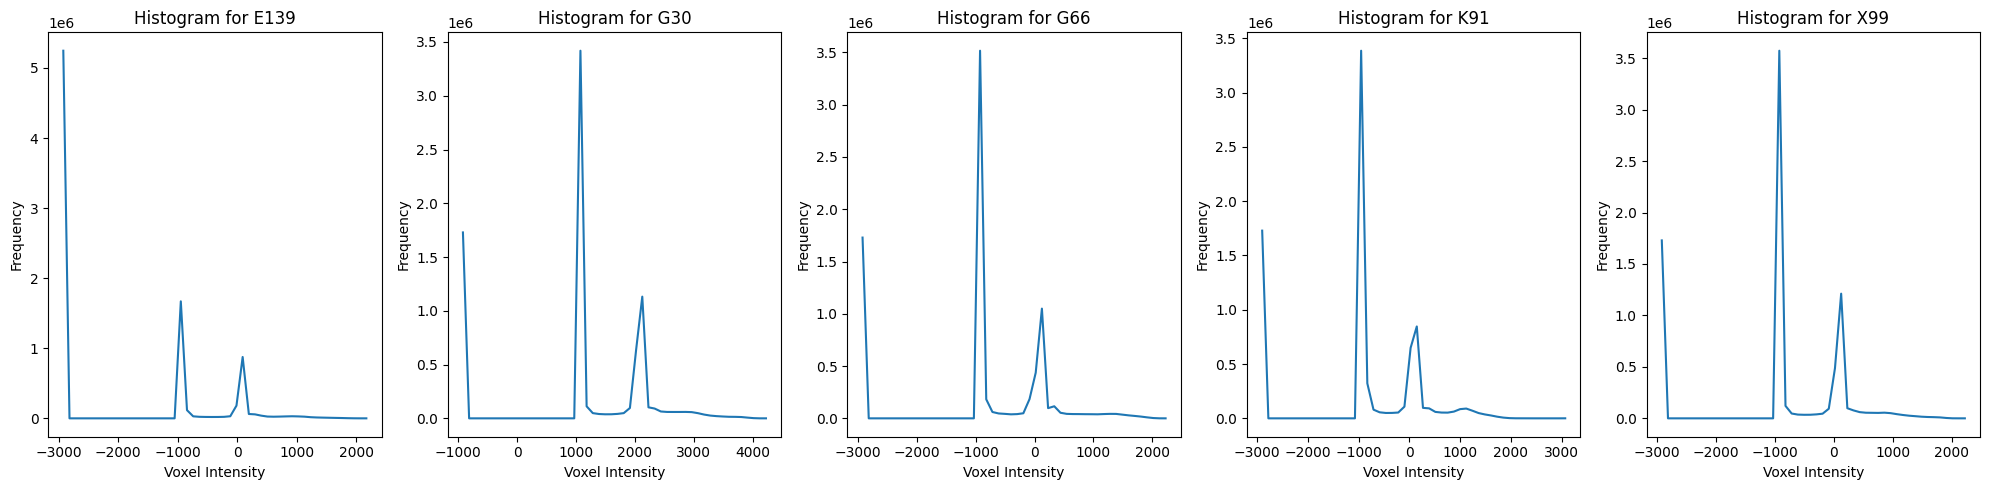

In [63]:
# 1. Compute the image histogram and plot all histograms side by side
histograms = []
for i, image in enumerate(images):
    # Compute histogram
    hist, bin_edges = np.histogram(image.flatten(), bins=50)
    histograms.append((patient_names[i], hist, bin_edges))  # Store histogram with patient name

# Plot all histograms side by side
plt.figure(figsize=(20, 5))  # Adjust the figure size for better visibility
for i, (patient_name, hist, bin_edges) in enumerate(histograms):
    plt.subplot(1, len(histograms), i + 1)
    plt.title(f'Histogram for {patient_name}')
    plt.xlabel('Voxel Intensity')
    plt.ylabel('Frequency')
    plt.plot(bin_edges[1:], hist)

plt.tight_layout()
plt.show()

#### Normal Patient Histograms
**Patients:** G66, K91, and X99

Their histogram has 3 peaks:

- **First Peak:** 
  - Centered at 0 Voxel Intensity 
  - Around 1 * 10<sup>6</sup> Frequency
  
- **Second Peak:** 
  - Centered at -1000 Voxel Intensity 
  - Around 3.5 * 10<sup>6</sup> Frequency
  
- **Third Peak:** 
  - Centered at -3000 Voxel Intensity 
  - Around 1.5 * 10<sup>6</sup> Frequency


#### Abnormal Patient Histograms

##### E139:

- **First Peak:** 
  - Centered at 0 Voxel Intensity 
  - Around 1 * 10<sup>6</sup> Frequency
  
- **Second Peak:** 
  - Centered at -1000 Voxel Intensity 
  - Around 2 * 10<sup>6</sup> Frequency *abnormal from others in frequency*
  
- **Third Peak:** 
  - Centered at -3000 Voxel Intensity 
  - Around 5 * 10<sup>6</sup> Frequency *abnormal from others in frequency*


##### G30:

- **First Peak:** 
  - Centered at 2000 Voxel Intensity 
  - Around 1 * 10<sup>6</sup> Frequency *abnormal from others in voxel intensity*
  
- **Second Peak:** 
  - Centered at 1000 Voxel Intensity 
  - Around 3.5 * 10<sup>6</sup> Frequency *abnormal from others in voxel intensity*
  
- **Third Peak:** 
  - Centered at -1000 Voxel Intensity 
  - Around 1.5 * 10<sup>6</sup> Frequency *abnormal from others in voxel intensity*


### Visualize the masked images for abnormal patients

#### Patient E139

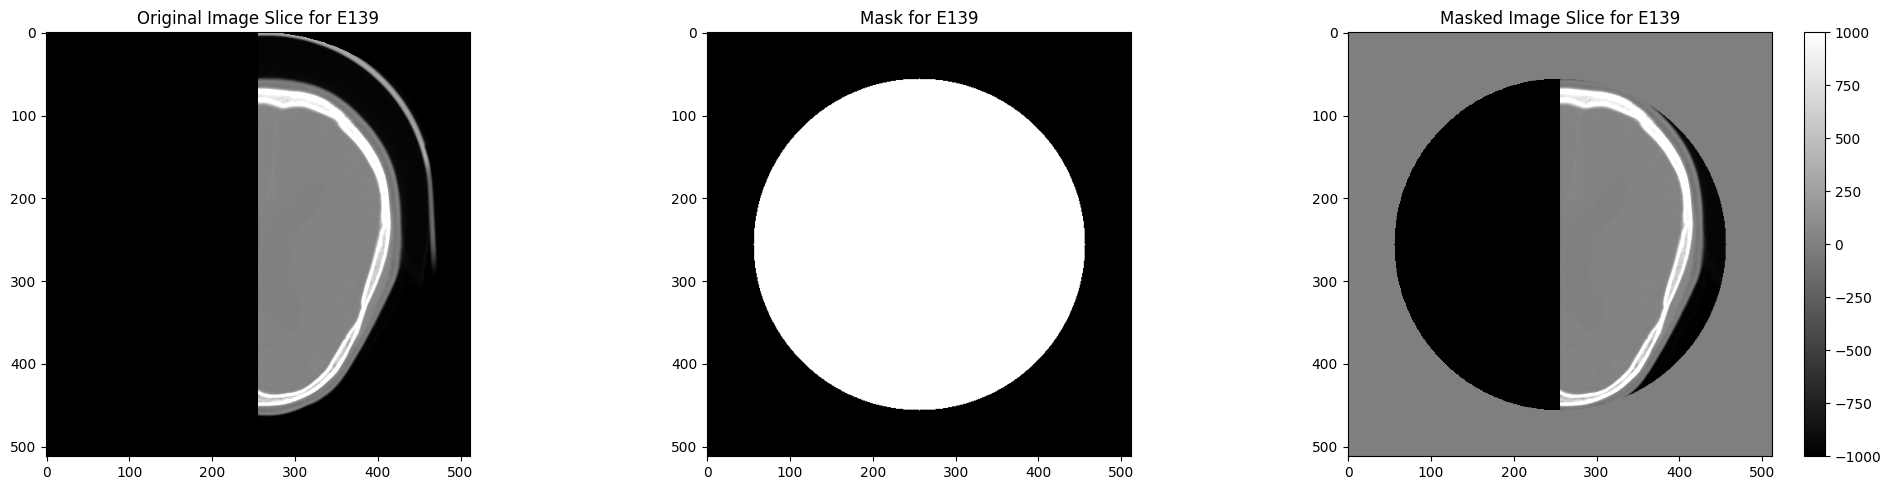

Analysis for Patient E139:
Scan is not valid as there is no information for half of the image


In [64]:
abnormal_patients = ['E139']

# Visualize the masked images for abnormal patients
for patient_name in abnormal_patients:
    idx = patient_names.index(patient_name)  # Get the index of the abnormal patient
    
    img = images[idx]
    mask = masks[idx]
    
    # Select the central slice
    central_slice_index = img.shape[0] // 2
    img_slice = img[central_slice_index]
    mask_slice = mask[central_slice_index]
    
    # Apply mask to image
    masked_image = img_slice * mask_slice
    
    # Visualization
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 3, 1)
    plt.title(f'Original Image Slice for {patient_name}')
    plt.imshow(img_slice, cmap='gray', vmin=-1000, vmax=1000)  # Set vmin and vmax for intensity range

    plt.subplot(1, 3, 2)
    plt.title(f'Mask for {patient_name}')
    plt.imshow(mask_slice, cmap='gray', vmin=0, vmax=1)
    
    plt.subplot(1, 3, 3)
    plt.title(f'Masked Image Slice for {patient_name}')
    plt.imshow(masked_image, cmap='gray', vmin=-1000, vmax=1000)  # Set vmin and vmax for intensity range
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

    # Comment on the region of interest based on histogram analysis
    print(f"Analysis for Patient {patient_name}:")
    print("Scan is not valid as there is no information for half of the image")


#### Patient G30

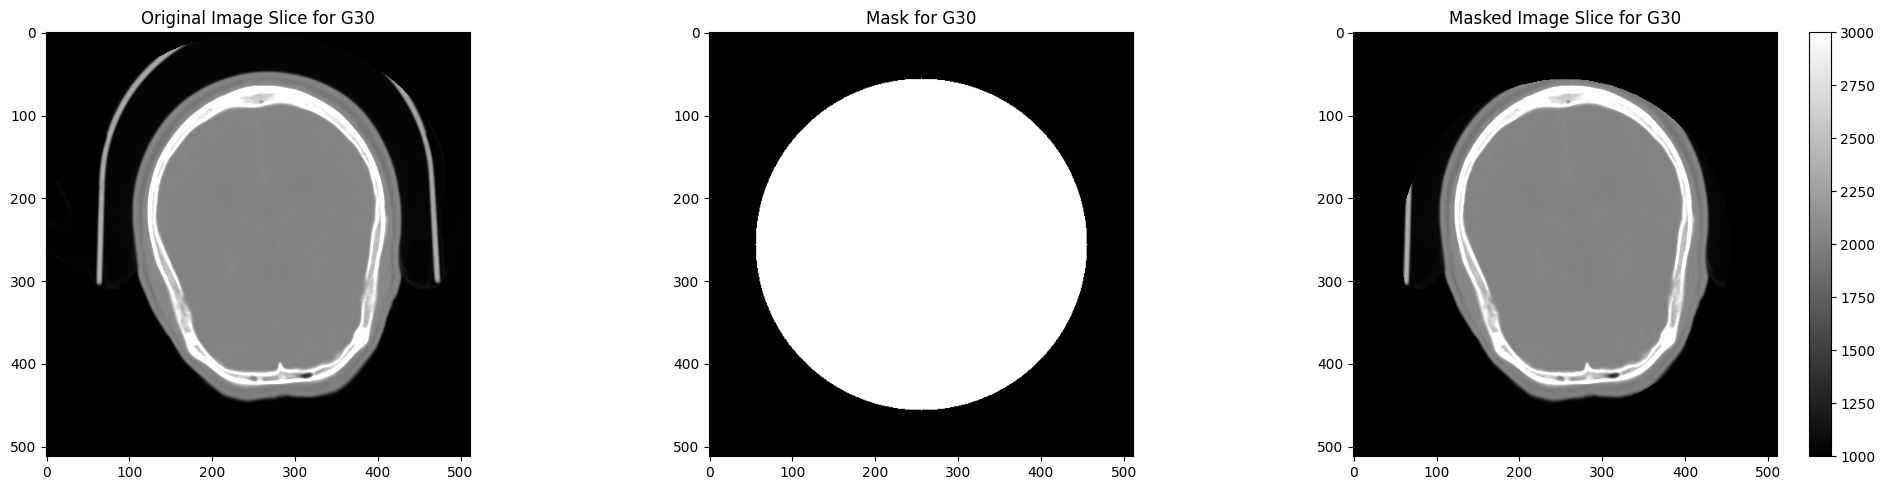

Analysis for Patient G30:
The scan is fine but the pixel intensity is too bright - over the range - so needs to be modified


In [65]:
abnormal_patients = ['G30']

# Visualize the masked images for abnormal patients
for patient_name in abnormal_patients:
    idx = patient_names.index(patient_name)  # Get the index of the abnormal patient
    
    img = images[idx]
    mask = masks[idx]
    
    # Select the central slice
    central_slice_index = img.shape[0] // 2
    img_slice = img[central_slice_index]
    mask_slice = mask[central_slice_index]
    
    # Apply mask to image
    masked_image = img_slice * mask_slice
    
    # Visualization
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 3, 1)
    plt.title(f'Original Image Slice for {patient_name}')
    plt.imshow(img_slice, cmap='gray', vmin=1000, vmax=3000)  # Set vmin and vmax for intensity range

    plt.subplot(1, 3, 2)
    plt.title(f'Mask for {patient_name}')
    plt.imshow(mask_slice, cmap='gray', vmin=0, vmax=1)
    
    plt.subplot(1, 3, 3)
    plt.title(f'Masked Image Slice for {patient_name}')
    plt.imshow(masked_image, cmap='gray', vmin=1000, vmax=3000)  # Set vmin and vmax for intensity range
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

    # Comment on the region of interest based on histogram analysis
    print(f"Analysis for Patient {patient_name}:")
    print("The scan is fine but the pixel intensity is too bright - over the range - so needs to be modified")
